In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Data Preparation**

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import os
import pathlib
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
import cv2
import skimage
from skimage.util import random_noise
import tensorflow as tf

from tqdm.notebook import tqdm
import random

In [ ]:
# Download files from Google drive using sharable link,
# https://stackoverflow.com/a/50670037/7697658
if 'NIND' not in os.listdir():
    !gdown https://drive.google.com/uc?id=1t5c3OUmHHDDvtpz4O-Gu_qrgggPxBAUW
    get_ipython().system_raw('7z x NIND.zip -o/content/ && rm NIND.zip')

Downloading...
From: https://drive.google.com/uc?id=1t5c3OUmHHDDvtpz4O-Gu_qrgggPxBAUW
To: /content/NIND.zip
3.22GB [00:43, 74.7MB/s]


In [ ]:
# Download files from Google drive using sharable link,
# https://stackoverflow.com/a/50670037/7697658
if 'Mi3_Aligned' not in os.listdir():
    !gdown https://drive.google.com/uc?id=1MrcCSnM3Weu7Wi-n0iNBxfFYlHy0ZUpX
    get_ipython().system_raw('7z x Mi3_Aligned.zip -o/content/ && rm Mi3_Aligned.zip')

Downloading...
From: https://drive.google.com/uc?id=1MrcCSnM3Weu7Wi-n0iNBxfFYlHy0ZUpX
To: /content/Mi3_Aligned.zip
2.71GB [00:43, 62.9MB/s]


In [ ]:
# Extract zip files to a destination directory,
# https://askubuntu.com/a/1049564
if 'SIDD_Small_sRGB_Only' not in os.listdir():
    !gdown https://drive.google.com/uc?id=1uhBXtYT2BZEbHEShTBw4KKOjj3SUnHrD
    get_ipython().system_raw('7z x SIDD_Small_sRGB_Only.zip -o/content/ && rm SIDD_Small_sRGB_Only.zip')

Downloading...
From: https://drive.google.com/uc?id=1uhBXtYT2BZEbHEShTBw4KKOjj3SUnHrD
To: /content/SIDD_Small_sRGB_Only.zip
6.62GB [01:46, 77.7MB/s]


In [ ]:
def get_images_paths(root_dir_ssid, root_dir_mi, root_dir_nind):
    # Getting SSID dataset images
    root = pathlib.Path(root_dir_ssid)
    img_paths = list(root.rglob("*.PNG*"))
    img_paths_lst = [str(path) for path in img_paths]

    gt_lst = []
    noisy_lst= []
    for p in img_paths_lst:
        img_type = p.split("/")[-1].split('_')[-3]
        if img_type=="NOISY":
            noisy_lst.append(p)
        elif img_type=="GT":
            gt_lst.append(p)

    # Getting mi dataset images
    root = pathlib.Path(root_dir_mi)
    img_paths = list(root.rglob("*.bmp*"))
    img_paths_lst = [str(path) for path in img_paths]

    for p in img_paths_lst:
        img_type = p.split("/")[-1].split('_')[-1]
        if "Noisy" in img_type:
            noisy_lst.append(p)
        elif "Reference" in img_type:
            gt_lst.append(p)
            gt_lst.append(p)


    # Getting NIND dataset images
    root = pathlib.Path(root_dir_nind)
    img_paths = list(root.rglob("*.png*"))
    img_paths.extend(list(root.rglob("*.jpg*")))
    img_paths_lst = [str(path) for path in img_paths]

    for p in img_paths_lst:
        img_type = p.split("/")[-1].split("_")[-1]
        if "H" in img_type:
            noisy_lst.append(p)
        else:
            gt_lst.append(p)

    noisy_array = np.asarray(noisy_lst)
    gt_array = np.asarray(gt_lst)
    return noisy_array, gt_array

In [ ]:
# # SANITY CHECK of the NIND image pairs
# for p, q in zip(noisy_lst, gt_lst):
#     n_file_name = p.split("/")[2]
#     n_file_name = n_file_name[n_file_name.find("_"):n_file_name.rfind("_")+1]

#     g_file_name = q.split("/")[2]
#     g_file_name = g_file_name[g_file_name.find("_"):g_file_name.rfind("_")+1]

#     if n_file_name!=g_file_name:
#         print("Something's wrong, I can feel it!",n_file_name,g_file_name)

In [ ]:
# # SANITY check of the mi phone image pairs
# noisy_array_paths, gt_array_paths = get_images_paths("SIDD_Small_sRGB_Only", "Mi3_Aligned")
# somethings_wrong=False
# mi_counter=0
# for gt_path, noisy_path in zip(gt_array_paths, noisy_array_paths):
#     batch_gt = gt_path.split("/")[1]
#     batch_noisy = noisy_path.split("/")[1]
#     if gt_path.split("/")[0]=="Mi3_Aligned":
#         mi_counter+=1
#         if batch_gt!=batch_noisy:
#             print(gt_path+" -- "+noisy_path)
#             somethings_wrong=True
#             break
# if somethings_wrong:
#     print("Something's wrong, I can feel it!", mi_counter)
# else:
#     print("Nothing to worry!", mi_counter)

In [ ]:
from sklearn.model_selection import train_test_split

noisy_array_paths, gt_array_paths = get_images_paths("SIDD_Small_sRGB_Only", "Mi3_Aligned", "NIND")

noisy_train_paths, noisy_test_paths, gt_train_paths, gt_test_paths = train_test_split(noisy_array_paths, gt_array_paths, test_size=0.20, random_state=42)

In [ ]:
print(noisy_train_paths.shape)
print(noisy_test_paths.shape)
print(gt_train_paths.shape)
print(gt_test_paths.shape)

(241,)
(61,)
(241,)
(61,)


In [ ]:
# Get gt_images in memory
def get_images_in_mem(images_paths):
    images_lst = []
    for img_path in tqdm(images_paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        images_lst.append(img)
    return np.array(images_lst)

In [ ]:
noisy_train_images = get_images_in_mem(noisy_train_paths)
noisy_test_images = get_images_in_mem(noisy_test_paths)

gt_train_images = get_images_in_mem(gt_train_paths)
gt_test_images = get_images_in_mem(gt_test_paths)

print(noisy_train_images.shape)
print(noisy_test_images.shape)

print(gt_train_images.shape)
print(gt_test_images.shape)


(241, 256, 256, 3)
(61, 256, 256, 3)
(241, 256, 256, 3)
(61, 256, 256, 3)


# **Traditional Filter: Non-local means**

In [ ]:
from skimage.restoration import denoise_nl_means, estimate_sigma

def inference_images(noisy_images):
    dn_images=[]
    for i in tqdm(range(len(noisy_images))):
        sigma_est = np.mean(estimate_sigma(noisy_images[i], multichannel=True))
        patch_kw = dict(patch_size=5,      # 5x5 patches
                    patch_distance=6,  # 13x13 search area
                    multichannel=True)
        dni = denoise_nl_means(noisy_images[i], h=1.15 * sigma_est, sigma=sigma_est, fast_mode=False,**patch_kw)
        dn_images.append(dni)
    return np.array(dn_images)

denoised_images = inference_images(noisy_test_images)

Text(0.5, 1.0, 'Predicted')

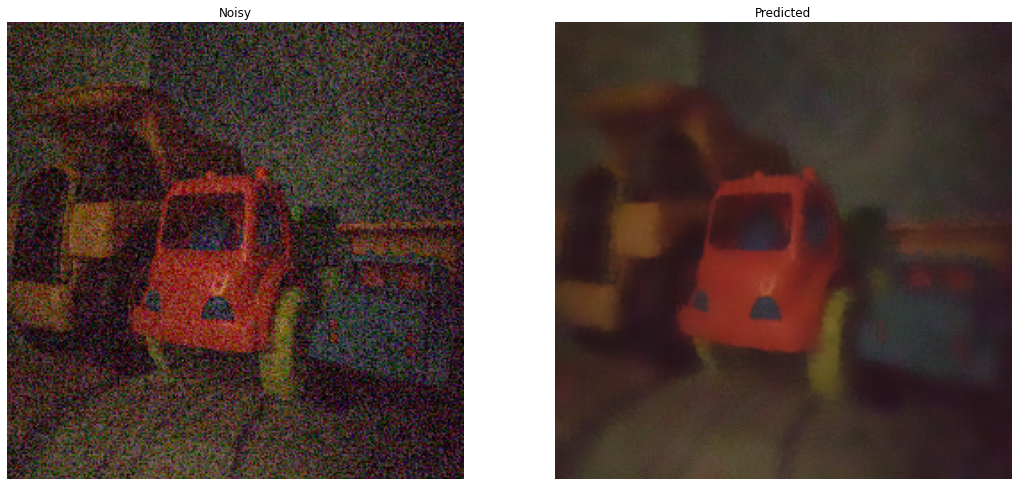

In [ ]:
idx = 16
f, ax = plt.subplots(1,2, figsize=(18,18))
ax[0].imshow(noisy_test_images[idx])
ax[0].axis('off')
ax[0].set_title('Noisy')

ax[1].imshow(denoised_images[idx]/255)
ax[1].axis('off')
ax[1].set_title('Predicted')

In [ ]:
from skimage.metrics import peak_signal_noise_ratio

psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images, noisy_test_images, denoised_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images.shape[0]
psnr_prediction_mean/=gt_test_images.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

Original average gt-noisy PSNR -> 25.56813169584183
Predicted average gt-predicted PSNR -> 30.439690563817248


In [ ]:
from skimage.metrics import structural_similarity as ssim

ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images, noisy_test_images, denoised_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images.shape[0]
ssim_prediction_mean/=gt_test_images.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)

Original average gt-noisy SSIM -> 0.574856358823499
Predicted average gt-predicted SSIM -> 0.761889699303151


# **PRIDNet prediction [Deep Learning]**

In [ ]:
# PRIDNet model
best_models_path = "/content/drive/MyDrive/Colab Notebooks/Applied AI Assignments/Case Study 2 Image Denoising/Best Models/PRIDNet model/"
model = tf.keras.models.load_model(best_models_path+'best_PRIDNet_blindnoise_256x256.h5', custom_objects={'Convolutional_block': Convolutional_block,
                                                                                                        'Channel_attention':Channel_attention,
                                                                                                        'Avg_pool_Unet_Upsample_msfe':Avg_pool_Unet_Upsample_msfe,
                                                                                                        'Multi_scale_feature_extraction':Multi_scale_feature_extraction,
                                                                                                        'Kernel_selecting_module':Kernel_selecting_module})

In [ ]:
# Inference
def inference_single_image(model, noisy_image):
    input_image = np.expand_dims(noisy_image, axis=0)
    predicted_image = model.predict(input_image)
    
    return predicted_image[0]

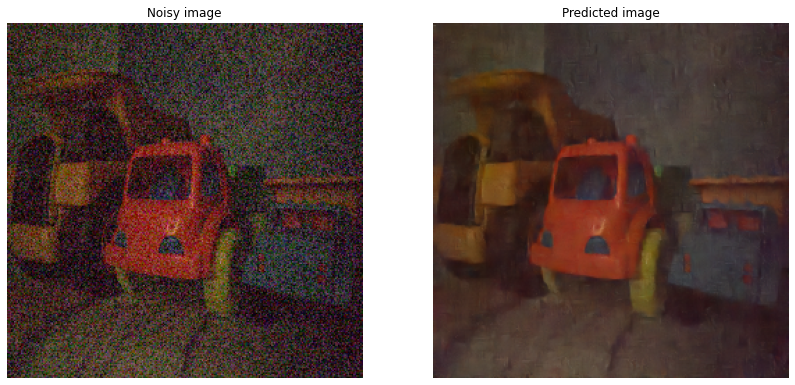

In [ ]:
# Test image prediction
predicted_image = inference_single_image(model, noisy_test_images[idx])
predicted_image/=255

f, axarr = plt.subplots(1,2, figsize=(14,14))
axarr[0].imshow(noisy_test_images[idx])
axarr[0].title.set_text("Noisy image")
axarr[0].set_axis_off()

axarr[1].imshow(predicted_image)
axarr[1].title.set_text("Predicted image")
axarr[1].set_axis_off()